In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
%matplotlib inline
import folium
import string
from helpers import *

ALPHA = string.ascii_letters
pd.options.mode.chained_assignment = None  # default='warn'

# What's on my plate?

As a reminder, our initial research questions are:

- What is the proportion of imported/exported products per country?
- Which countries sell the highest variety of eco-friendly products in terms of packaging and CO2 footprint?
- Which countries have the largest variety of organic-labeled products?
- What is the average nutrition score of every product category?
- What ingredients imply a better nutrition score (or vice-versa)?

From those in mind, we will analyse the dataset in order to see which features would be usefull to answer them and and most of all find if there is enough data to answer them!

# Data cleaning

### Loading the CSV file
The CSV File is stored on our computer with the name `OpenFood.csv`. From opening it with a text editor, we found out that the cells are separated by tabulations (i.e. by the `\t` character). Even though the file size is approximately 1.7 GB, we still manage to fit it in a dataframe. We start by opening it:

In [3]:
path = ""
file_name = "OpenFood.csv"
data_path = path+file_name
df = pd.read_csv(data_path, sep = '\t')

/Users/Mathias/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,3,5,24,25,26,28,36,41,49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### DataFrame Exploration

We first have a look at the dataset

In [4]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000949,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1523440813,2018-04-11T10:00:13Z,1523440823,2018-04-11T10:00:23Z,Salade de carottes râpées,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


With this first look at the DataFrame we can immediately remove the following columns as they are useless for our research purposes:

In [5]:
columns_to_drop = [
    'url',
    'creator',
    'created_t',
    'created_datetime',
    'last_modified_t',
    'last_modified_datetime',
    'generic_name',
    'quantity',
    'emb_codes',
    'emb_codes_tags',
    'purchase_places',
    'stores',
    'traces',
    'traces_tags',
    'serving_size',
    'no_nutriments',
    'image_url',
    'allergens', 
    'image_small_url',
    'manufacturing_places_tags',
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url',
    'states',        
    'states_en',
    'states_tags',
    'serving_quantity',
    'traces_en',
    'allergens_en',
    'ingredients_that_may_be_from_palm_oil',
    'ingredients_from_palm_oil'
]

In [6]:
# Drop the colums and put the result in a new data frame called df2
df2 = df.drop(columns_to_drop, axis=1)

It is hard to get an idea of what the values are as there are loads of NaN values... To get a better idea of the values from the dataframe, we show the unique values of each columns:

In [ ]:
# We create a new dataframe
df_unique = pd.DataFrame()

# For each column
for col in df2.columns:
    # We take only the unique values of every column
    df_unique = pd.concat([df_unique, pd.Series(df2[col].unique())], ignore_index=True, axis=1, copy=False)
df_unique.columns= df2.columns

In [ ]:
df_unique.head()

Since there is a large number of NaN values we also show the number of non NaN values of each column along with the number of different values in each of the columns:

In [ ]:
# We initialize the columns to be used in the table that will be shown
cols = ['Number of non NaN values per column', 'Number of different values in each columns']

# We create a table to show the informations
describe_df = pd.DataFrame([df2.count(),df_unique.count()]).transpose()
describe_df.columns = cols
describe_df['ColNumber'] = np.arange(df_unique.shape[1])
describe_df.head(10)

After further looking into the dataset, we see that there are some columns that are redundant such as `packaging` and `packaging_tags` so we keep only one of the two. For this specific example we only keep the `packaging_tags` column as the values are more consistent. We also remove some other columns. The reasons for the removal are stated as comment in the cell below:

In [ ]:
columns_to_drop_2 = [
    'packaging', # The values are redundant and be used in packaging_tags
    'brands', # brands_tags has more stable (same rows are represented in different ways) values
    'categories', # categories_tags has more stable values
    'categories_en', # categories_tags has more stable values
    'origins', # origins_tags has more stable values
    'labels', # labels_tags has more stable values
    'labels_en', # labels_tags has more stable values
    'first_packaging_code_geo', # Not interesting for our research questions
    'cities', # Contains only NaN values and not really intresting for our research questions
    'cities_tags', # Contains only NaN values and not really intresting for our research questions
    'countries', # Seem to contain useless duplicated values (France, en:FR, en:france,...)
    'countries_en', # The countries_tags column gives a more stable result
    'ingredients_text', # too hard to deal with and not really intresting after seeing the values
    'additives', # Not needed for our research question, only the number of additives can be interesting
    'additives_en', # Not needed for our research question, only the number of additives can be interesting
    'ingredients_that_may_be_from_palm_oil_n', # As we already keep ingredients_from_palm_oil_n
    'ingredients_that_may_be_from_palm_oil_tags', # As we already keep ingredients_from_palm_oil_n
    'nutrition_grade_fr', # Contains only NaN values
    'ingredients_from_palm_oil_tags', # Not useful for our research
    'ingredients_from_palm_oil_n', # Not useful as well
    'main_category_en' # The main_category column has more stable values
]

Now for the nutrition facts we can delete all the columns that have less than 1000 values (count) because if they do, it means that the columns are too specific (like type of sugar) or there aren't enough values in the dataset in the columns to be interessting. Note this means we have to drop the idea of analyzing the carbon footprint as there aren't enough values to answer our carbon foot print analysis

In [ ]:
# Creating the list of all the food fact (ingredients) column to delete since we do not need them for our research
describe_df_aux = describe_df.iloc[36:]

# We set them as a list for the removal
food_facts_to_drop = list(describe_df_aux.index.values)

# We remove the nutrition score from the list since they are needed
food_facts_to_drop.remove('nutrition-score-fr_100g')
food_facts_to_drop.remove('nutrition-score-uk_100g')

Now that we have the two lists we can merge them and then drop the columns:

In [ ]:
# Merging the two list created above to remove them
columns_to_drop_merged = columns_to_drop_2 + food_facts_to_drop
# Deleting and storing in a new dataframe
df3 = df2.drop(columns_to_drop_merged, axis = 1)

Now we can wonder if the `code` column can be set as the index:

In [ ]:
df3.code.is_unique

So the code column is not unique let's see how many values are duplicated:

In [ ]:
# We take all the rows where the code is duplicates
duplicate_codes_indices = np.where(df3.duplicated('code', keep=False).values)[0]
dups = df3.iloc[duplicate_codes_indices].copy()
dups.code = dups.code.astype(float)

# We sort so that the duplicated rows are on top of each other
dups.sort_values(by = 'code', inplace = True)

# Show the result
dups.head()

As it can be seen there are two types of duplicates:
Some codes (`code` column) appear twice and some codes are NaN. As it can be observed when codes are duplicated, they are often the same product and sometimes one of the rows contains more information than the other for the same code. So we could just keep the rows that contain the most information. And for the rows with NaN as code, the values of the columns are not matching the column names so there must be a shift of values. As a lot of values are missing, it would be complex to recover the true data and there are only 34 rows with code equal to NaN, so we can delete them:

In [ ]:
dups = dups[dups != float('nan')]

dups['nb_of_features'] = np.sum(dups.notnull(), axis=1)
dups.reset_index(inplace = True)
indices_to_remove = dups.sort_values(['code','nb_of_features'],ascending = True)\
                        .groupby('code',as_index=False).first()['index'].values
df3.dropna(subset=['code'],inplace=True)
df3.drop(indices_to_remove,inplace = True)

We verify that the `code` column of the dataframe is unique:

In [ ]:
df3.code.is_unique

So we just have to set this column as the index:

In [ ]:
df3.set_index('code', inplace = True)

The dataframe has the following shape:

In [ ]:
print('{0}(row) x {1}(columns)'.format(df3.shape[0], df3.shape[1]))

So we are using these proportions of the initial dataframe:

In [ ]:
print('{0:1.2f}% of the rows of the initial dataframe'.format(df3.shape[0]/df.shape[0]*100))
print('{0:1.2f}% of the columns of the initial dataframe'.format(df3.shape[1]/df.shape[1]*100))

### Types and statistics of the features

Let's first check what are the type of the columns of the dataframe:

In [ ]:
df3.dtypes

Here the types are object as there are a lot of NaN values (which are float type) in the text so the python compiler can put string as type. We will be able to replace some of the NaN values later.

Let's plot the percentage of the non NaN values in each general information features i.e. column 0 to 18. The data set is split with respect to some groups of columns to have make a better representation of each category of feature:

In [ ]:
general_info = df3.iloc[:,:18]
plt.figure(figsize=(20,6))
plt.bar(range(general_info.shape[1]),general_info.count()/general_info.shape[0]*100)
plt.xticks(range(general_info.shape[1]), general_info.columns,rotation=70)
plt.title("Percentage of non-NaN values for each feature")
plt.xlabel("Feature Name")
plt.ylabel("Percentage of non-NaN values [%]")
plt.show()

As expected from looking at the data frame, there is a large number of NaN values. Indeed, for the `origin_tags` there is more than 95% of the values that are NaN values. This is compromising a lot with our research question about import/export. On the other hand, from the `df_unique` dataframe we see that there is still ~50'000 rows that contain an origin tags so we will still be able to do some research (though not as extended as we wished) on a subset of rows.

We also plot an histogram of the count of non-NaN values for each row:

In [ ]:
# Plotting 
plt.figure(figsize=(18,6))
plt.subplot(121)
plt.hist(general_info.transpose().count(),
         bins = np.arange(general_info.shape[1]+2)-0.5,
         rwidth = 0.8)
plt.xticks(range(general_info.shape[1]+1))
plt.title("Histogram of the number of non-NaN values")
plt.xlabel("Number of non-NaN values")
plt.ylabel("Count")

plt.subplot(122)
plt.hist(general_info.transpose().count(),
         bins = np.arange(general_info.shape[1]+2)-0.5, 
         cumulative=True,
         rwidth = 0.8)
plt.xticks(range(general_info.shape[1]+1))
plt.title("Cumulative histogram of the number of non-NaN values")
plt.xlabel("Number of non-NaN values")
plt.ylabel("Count")
plt.show()

By seeing the problem row-wise, we can evaluate the amount of data that we will be able to use. We can see the distribution on the left to get a general idea of the number of non-NaN values for each row. But the most interesting plot is the cumulative on the right. We can see that more than 400'000 rows have more than 5 non-NaN values (out of 15 columns in total). Hence, we will still be able to play with a lot of data even though we will have to drop loads of rows. We still have to figure out what threshold. This is depending on what specific aspect is studied!

### Importing a second data set with all the countries locations

In [ ]:
# CSV found on this page: https://developers.google.com/public-data/docs/canonical/countries_csv
countries_df = pd.read_csv("countries.csv", sep = '\t')

# Remove the space at the end of the column names
countries_df.columns = ['country', 'latitude', 'longitude', 'name']

# Setting country as Index
countries_df.set_index('country', inplace = True)
countries_df.head(10)

With this second data set we will be able to see how the products travel across the world. To be more specific, we wil be able to compute the distance traveled from the countries coordinates on the map (by computing the grand circle distance). As we all know, the fact of importing food that comes from far away is bad for the environment. Mainly for vegetable as they have to travel most of the time by plane otherwise they get quickly out of date.

# More analysis of the research questions

### What is the proportion of imported/exported products per country?

With both `origins_tags` and `countries_tags`, we can extract the countries that import and export the most number of products. We can assume that the name of the product are unique and therefore can be used to look for the number of products sold in or are being sold by a particular country. The countries and origins tags are not cleaned yet, but it is definitely possible to search whether it might countain the name of a known country or the abbreviation of it to do or from one of its cities. We also plan to extract the known coordinate for every country and map them to the origins_tags and countries_tags and display the flow of products inward or outward from every single country and its volume on a world map to know what country produces the most of the products used worldwide or the one that imports the most of its products. With the second data frame we imported, we will be able to show the distance traveled by the product (using the great distant circle) in the world.

In [ ]:
# The number of unique values for origins_tags
len(df3["origins_tags"].unique())

In [ ]:
# The number of unique values for countries
len(df3["countries_tags"].unique())

In [ ]:
# Number of products sold in a specific country
df3.copy().groupby(by = ['countries_tags'])["product_name"].count().head()

In [ ]:
# Number of products made in a specific country
df3.copy().groupby(by = ['origins_tags'])["product_name"].count().head()

We notice that the aggregation by `countries_tags` has 6681 possible unique values (excluding NaN) which is much more than the possible number of countries in the world. After exploring the countries_tags, we observe the some products are sold in more than a single country, and the combination of all the product in which it is sold is considered a single entry for `origins_tags`. Thus, a seperation of the `countries_tags` is neccessary and reaggregation of the all the products.

We also notice that origins_tags has 1237 unique values (excluding NaN) whici is more than the possible number of countries in the world. After exploring origins_tags, we observe the some origin_tags are more specific about the origins than just including the country. We should clean this column by looking at whether it contains a known name of a country.

### Which countries sell the highest variety of eco-friendly products in terms of packaging and CO2 footprint?

As explained earlier, the column `carbon-footprint_100g` has less than 1000 values. This jeopardizes this research question on one hand since CO2 footprint is a vital aspect and the data is lacking. As a result, we will not be using the CO2 footprint in this research question since we have decided to remove the column. On the other hand, we will be able to move forward by analyzing the `packaging_tags` column. <br>
Let's see if the `packaging_tags` and `countries_tags` column have enough data for this question:

In [ ]:
df3['packaging_tags'].count()

In [ ]:
df3['countries_tags'].count()

We notice that the data relative to the packaging has more than 140,000 non-NaN values and the data relative to the country where is it ***sold*** is present in nearly all products. In this sense, by using the information of the packaging along with the column `countries_tags`, we can estimate the countries that sell the highest variety of eco-friendly products but only in terms of packaging

### Which countries have the largest variety of organic-labeled products? 

This research question appeals to three different columns: `countries_tags`, `categories_tags` and `labels_tags`. The labels and categories have data about wether the products are organic or not, while the countries will be used to identify which of the countries have the largest variety of organic-labeled products.

In [ ]:
df3['categories_tags'].count()

We see that we have data of the categories for more than 180,000 products. As a result, this column has enough data to be considered for this research question.

In [ ]:
df3['labels_tags'].count()

We also notice that we have data of the labels for more than 100,000 products. As a result, this column has enough data to be considered for this research question. <br>
Since we know that the `countries_tags` column is filled for almost every product, we can conclude that this research question can be answered by looking at the organic labels in `labels_tags` and possibly `categories_tags` and mapping the labels to the countries from `countries_tags`.

### What is the average nutrition score of every product category? 

In order to answer this research question, we will be diving into the `nutrition-score-fr_100g`, `nutrition-score-uk_100g` as well as some columns about the categories: `categories_tags`, `main_category`, `pnns_groups_1` and `pnns_groups_2`. Since we have already seen the number of non-NaN values for `categories_tags` above, we can now analyze the other columns that can be very helpful for this research question 

In [ ]:
df3['nutrition-score-fr_100g'].count()

In [ ]:
df3['nutrition-score-uk_100g'].count()

We notice that `nutrition-score-uk_100g` and `nutrition-score-fr_100g` have the exact same number of the non-NaN values. We can check how similar they are columns.

In [ ]:
df3['nutrition-score-uk_100g'].corr(df3['nutrition-score-fr_100g'])

The two columns are 93% similar. We can then move on with only one of the columns since they are nearly exactly the same. <br> Let's analyze further the columns related to the product category.

In [ ]:
print(df3['main_category'].count())
print(df3['pnns_groups_1'].count())
print(df3['pnns_groups_2'].count())

We notice that for every column that is related to the category of the product, we do indeed have enough data (at least 180,000 products). By mapping the categories to the nutrition score, we can find out the average nutrition score for every category.

## Answering the research questions 

We first change the name of our dataframe for better readability. 

In [ ]:
current_data = df3

First of all, we need to some more cleaning for columns that will be relevant later, such as `countries_tags`

In [ ]:
current_data['countries_tags'].head()

We notice that the name of the countries comes after the :, we can then take the substring starting from ":".

In [ ]:
# We make a copy of the column
countries = current_data['countries_tags'].astype(str)

# We split and take the second element, for example en:france would return france
countries = countries.str.split(':').str.get(1)

# We capitalize the first letter
countries = countries.str.capitalize()

# Some results are United-states, we remove the "-" for better readability
countries = countries.str.replace("-", " ")

# We check the result
countries.unique()

While the result is satifsying, we still notice that some countries have their name followed by either ",en", ",fr", ",de", ",ch", ",it", ",sq" or ",es". We can remove them to only keep the country. Moreover, some country names are "To be checked", however we should not remove them because those rows may contain data that is relevant to other research questions.

In [188]:
# We remove the names that contain extra characters that are not needed. Since they are not a lot, 
# we can do it manually.
countries = countries.str.replace(",en", "")
countries = countries.str.replace(",fr", "")
countries = countries.str.replace(",de", "")
countries = countries.str.replace(",ch", "")
countries = countries.str.replace(",it", "")
countries = countries.str.replace(",sq", "")
countries = countries.str.replace(",es", "")

# We also replace the values representing the same country to the country that is represented
countries = countries.str.replace("Suisse", "Switzerland")

countries = countries.str.replace("French polynesia", "France")
countries = countries.str.replace("French guiana", "France")
countries = countries.str.replace("Martinique", "France")
countries = countries.str.replace("Guadeloupe", "France")
countries = countries.str.replace("New caledonia", "France")
countries = countries.str.replace("Reunion", "France")
countries = countries.str.replace("Frankreich", "France")
countries = countries.str.replace("Frankrike", "France")
countries = countries.str.replace("Frankrijk", "France")

countries = countries.str.replace("Deutschland", "Germany")
countries = countries.str.replace("Allemagne", "Germany")

# We put countries into a dataframe
countries_in_df = countries.to_frame()

# Removing "European union" as it is also not a country
current_data = current_data[current_data['countries_tags'] != "European union"]

Now that the column is cleaned, we can set it as the column of our dataframe

In [189]:
current_data['countries_tags'] = countries_in_df['countries_tags']

### What is the proportion of imported/exported products per country?

In [ ]:
# All the fucntions used in this cell are stored in the helpers.py file at root level of the git repository
# They were placed here as their number of lines sum up to 250 line of code

# Furhter cleaning of the countries tags
ct = clean_coutries_tags(current_data)
current_data['countries_tags'] = ct

ot = clean_origins_tags(current_data)
current_data['origins_tags'] = ot

mt = clean_manufact(current_data)
current_data['manufacturing_places'] = mt

In [ ]:
ori_tags = current_data[['origins_tags','product_name']].groupby('origins_tags').count().sort_values(by= 'product_name', ascending=False).iloc[1:]
plt.figure(figsize=(15,6))
plt.barh(ori_tags.head(20).index, ori_tags.head(20).product_name, log=True)
plt.show()

In [ ]:
ctry_tags = current_data[['countries_tags','product_name']].groupby('countries_tags').count().sort_values(by= 'product_name', ascending=False)
plt.figure(figsize=(15,6))
plt.barh(ctry_tags.head(20).index, ctry_tags.head(20).product_name, log=True)
plt.show()

In [ ]:
manf_plce = current_data[['manufacturing_places','product_name']].groupby('manufacturing_places').count().sort_values(by= 'product_name', ascending=False).iloc[1:]
plt.figure(figsize=(15,6))
plt.barh(manf_plce.head(20).index, manf_plce.head(20).product_name, log=True)
plt.show()

In [ ]:
imp_exp = current_data[current_data['origins_tags'] != 'nan']
imp_exp = imp_exp[['countries_tags','origins_tags','product_name']].groupby(['countries_tags','origins_tags'])\
            .count()\
            .sort_values(by='product_name', ascending=False)
imp_exp.loc['France']

In [ ]:
imp_exp.loc['France'].iloc[:20].plot.bar()

In [ ]:
current_data[['origins_tags', 'product_name']].groupby('origins_tags').count().sort_values(by='product_name', ascending=False).head(20)

### Which countries contribute most to the environment through eco-friendly packages?

In order to answer this question, it is important to do some research to understand which packaging are the most/least eco-friendly. Online websites such as https://bizfluent.com/facts-6743400-eco-friendly-packaging-.html gave us some insights. First, we noticed that the 
Our research research has led to following conclusions:

In [150]:
# We first take the rows with a non-null value in packaging_tags
packaging_list_not_null = current_data[current_data['packaging_tags'].notnull()]

# We then take only the columns we are interested in: packaging_tags and countries_tags
packaging_list = packaging_list_not_null[['countries_tags','packaging_tags']]

# We put packaging_tags in a list, separate them by the "," which separates the different packaging
packaging_list['packaging_tags'] = packaging_list['packaging_tags'].str.split(',')

# We set the countries_tags as index to "explode" the list into different rows
packaging_list = packaging_list.set_index('countries_tags')
 
# We do the "explode" in order to have one package per row
packaging_list = (packaging_list.packaging_tags.apply(pd.Series)
              .stack()
              .reset_index(level=1, drop=True)
              .to_frame('packaging'))

# We reset the index
packaging_list = packaging_list.reset_index(level=0)

# Show the output
packaging_list.head(10)

,countries_tags,packaging
0,France,barquette
1,France,plastique
2,France,bocal
3,France,plastique
4,France,plastique
5,France,carton
6,France,plastique
7,France,plastique
8,France,carton
9,Canada,frais


Now that we have for each country what packaging it uses for each product, we need some way to quantify it. Thus, we create a dictionary containing for each packaging a certain grade, where the higher the grade the more it is eco-friendly. This dictionary is then converted to a dataframe to be used easily. We can then group by the country and take the mean (dividing by the number of products).

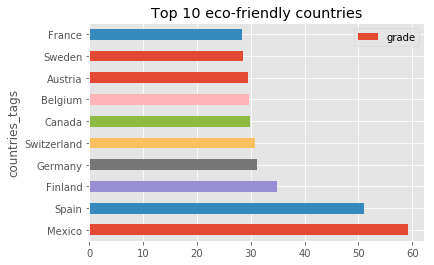

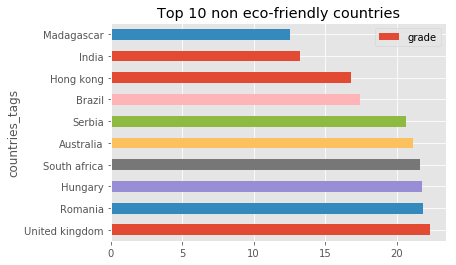

In [151]:
# Setting up the grades for each packaging type
# Note that we take the most common packaging types, where some appear in both french and english
# The highest the score, the more the packaging is eco-friendly
packaging_to_grade = {
    'carton':60,
    'cardboard':60,
    'papier':50,
    'paper':50,
    'verre':40,
    'glass':40,
    'metal':30,
    'canette':30, # Canette is considered as metal
    'aluminium':20,
    'plastique': 10,
    'sachet-plastique': 10,
    'plastic-bag': 10,
    'plastic': 10
}

# We create a dataframe from the dicionary
packaging_grade_df = pd.DataFrame.from_dict(packaging_to_grade, orient='index')
packaging_grade_df = packaging_grade_df.reset_index()
packaging_grade_df = packaging_grade_df.rename(columns={"index": "packaging", 0: "grade"})

# We then merge on the packaging type in order to have a grade for each packaging and each country
packaging_with_grade = packaging_list.merge(packaging_grade_df, how='left', left_on='packaging', right_on='packaging')

# We take only those with non-NaN grade (since we took only the most common packaging types, NaN may appear)
packaging_with_grade = packaging_with_grade[packaging_with_grade['grade'].notnull()]

# We noticed that some countries only have around 1 or 2 products which is not enough data
# We thus need to take into account only those that have a certain number of products, for example 10 products
# We duplicate the grade column and call it count_products
packaging_with_grade['count_products'] = packaging_with_grade['grade']

# We then group by the countries, and aggregate the obtain the mean for each country and the number of products
packaging_with_grade_count = packaging_with_grade.groupby('countries_tags').agg({'grade':'mean', 'count_products':'count'})

# We then take only those with more than 30 products
# This value is arbitrarily chosen after seeing that a lot of countries have less than 30 products
# More than 30 would reduce a lot the countries considered
final_packaging_grade = packaging_with_grade_count[packaging_with_grade_count['count_products'] >= 30]

# We sort the values
final_packaging_grade = final_packaging_grade.sort_values(by='grade', ascending=False)
final_packaging_grade = final_packaging_grade.reset_index(level=0)

# We take the top 10 and plot it
final_packaging_grade_top_10 = final_packaging_grade.head(10)
final_packaging_grade_top_10.plot.barh(x='countries_tags', y='grade', title='Top 10 eco-friendly countries')

# We take the bottom 10 and plot it
final_packaging_grade_bottom_10 = final_packaging_grade.tail(10)
final_packaging_grade_bottom_10.plot.barh(x='countries_tags', y='grade', title='Top 10 non eco-friendly countries')

### Which countries have the largest variety of organic-labeled products? 

In [ ]:
# We take only the rows that do not have a null label
labels_not_null = current_data[current_data['labels_tags'].notnull()]
categories_not_null = current_data[current_data['categories_tags'].notnull()]

# We take the rows with the label containing "organic" or "green" or "bio"
labels_not_null_organic = labels_not_null[labels_not_null['labels_tags'].str.contains('organic|green|bio')]

# We take the countries that have one of those labels
countries_with_labels_organic = labels_not_null_organic[['labels_tags', 'countries_tags']]

# We also take the number of products per country that just have a non-null label to compute a percentage
countries_with_labels_total = labels_not_null[['labels_tags', 'countries_tags']]
#print(countries_with_labels_total)

# We group by the country and take the count of the number of organic labeled product per country
countries_with_labels_organic = countries_with_labels_organic.groupby('countries_tags').count().sort_values(by='labels_tags', ascending=False)

# We group by the country and take the count of the number of labeled product per country
countries_with_labels_total = countries_with_labels_total.groupby('countries_tags').count().sort_values(by='labels_tags', ascending=False)

# Filter the countries that have less than 10 products
countries_with_labels_organic = countries_with_labels_organic[countries_with_labels_total.labels_tags >= 10]
countries_with_labels_total = countries_with_labels_total[countries_with_labels_total.labels_tags >= 0]

print(countries_with_labels_total)
print(countries_with_labels_organic)

countries_with_labels_organic_over_total = countries_with_labels_organic/countries_with_labels_total
countries_with_labels_organic_over_total.sort_values(by = "labels_tags", ascending = False, inplace = True)
countries_with_labels_organic_over_total.reset_index(drop=True, inplace=True)


countries_with_labels_organic_over_total['countries_tags'] = countries_with_labels_organic_over_total.index
countries_with_labels_organic_over_total.dropna(inplace = True)
#print(countries_with_labels_organic_over_total)


# WE SHOULD ALSO USE CATEGORIES TAGS, THEN DO A PERCENTAGE AND VISUALIZE ON A MAP IF WE HAVE ENOUGH DATA

In [ ]:
country_geo = 'world-countries-curated.json'
M = folium.Map(location=[100, 0], zoom_start=1)
# choropleth maps bind Pandas Data Frames and json geometries.
#This allows us to quickly visualize data combinations
M.choropleth(geo_data=country_geo, data=countries_with_labels_organic_over_total,
             columns=['countries_tags', 'labels_tags'],
             key_on='feature.properties.name',
             fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name="Percentage of organic food per country")
M

### What is the average nutrition score per country?

In [ ]:
current_data[~current_data['nutrition-score-uk_100g'].isna()].groupby('countries_tags')['nutrition-score-uk_100g'].mean().sort_values(ascending = False)

## So, what's on my plate?

We try to answer the following: given the location where we live, where does my food most likely come from? Is it eco-friendly? Is it healthy (from the nutrition grade)? How likely is it organic? 